In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import ast
from scipy.stats import norm, truncnorm
from sklearn.preprocessing import RobustScaler,MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error
from tensorflow.keras.layers import Dropout


In [2]:
metadatos=pd.read_csv("./Base_de_datos/metadata_normal.csv")
ciudades=pd.read_csv("./Base_de_datos/ciudades_normal.csv")
reviews_gm=pd.read_csv("./Base_de_datos/reviews_gm_normal.csv")
categorias=pd.read_csv('./Base_de_datos/categories_normalized.csv')
business=pd.read_csv('./Base_de_datos/business_normal.csv')  
reviews_yelp=pd.read_csv('./Base_de_datos/reviews_normal.csv')



In [3]:
metadatos.drop(columns=metadatos.columns[11:],inplace=True)
business.drop(columns=business.columns[11:],inplace=True)
metadatos_business=pd.concat([metadatos,business],axis=0,ignore_index=True)
metadatos_business.drop_duplicates(subset="id",ignore_index=True)

reviews=pd.concat([reviews_gm,reviews_yelp],axis=0,ignore_index=True)

In [4]:
metadatos_business.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26715 entries, 0 to 26714
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              26715 non-null  object 
 1   name            26715 non-null  object 
 2   street_address  15567 non-null  object 
 3   postal_code     26712 non-null  float64
 4   latitude        26715 non-null  float64
 5   longitude       26715 non-null  float64
 6   city_id         26715 non-null  int64  
 7   category_id     26715 non-null  object 
 8   stars           26715 non-null  float64
 9   review_count    26715 non-null  int64  
 10  is_open         26715 non-null  int64  
 11  address         10807 non-null  object 
dtypes: float64(4), int64(3), object(5)
memory usage: 2.4+ MB


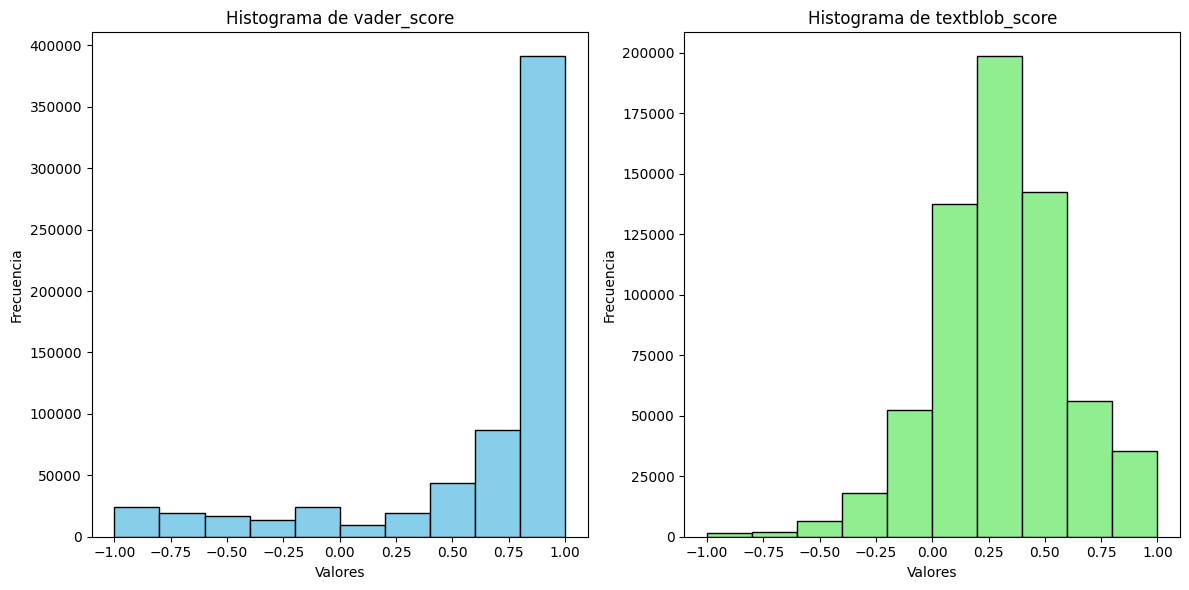

In [5]:
reviews_text=reviews[reviews["has_text"]!=0]

# Crear el bloque de histogramas
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Histograma para columna_1
axes[0].hist(reviews_text['vader_score'], bins=10, color='skyblue', edgecolor='black')
axes[0].set_title('Histograma de vader_score')
axes[0].set_xlabel('Valores')
axes[0].set_ylabel('Frecuencia')

# Histograma para columna_2
axes[1].hist(reviews_text['textblob_score'], bins=10, color='lightgreen', edgecolor='black')
axes[1].set_title('Histograma de textblob_score')
axes[1].set_xlabel('Valores')
axes[1].set_ylabel('Frecuencia')

# Ajustar el espacio entre los histogramas
plt.tight_layout()

# Mostrar los histogramas
plt.show()

In [6]:
print(f"Número de reviews totales: {reviews.shape[0]}")
print(f"Número de reviews totales con texto: {reviews_text.shape[0]}")

Número de reviews totales: 751917
Número de reviews totales con texto: 649952


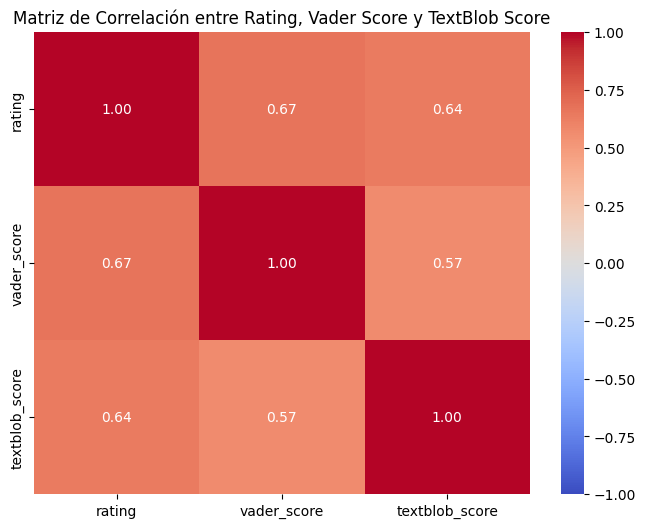

In [7]:
# Creamos un dtaframe solo con las reviews que tienen texto
reviews_text=reviews[reviews["has_text"]!=0]
# Calcular la matriz de correlación para las columnas 'rating', 'vader_score' y 'textblob_score'
correlation_matrix = reviews_text[['rating', 'vader_score', 'textblob_score']].corr()

# Crear un diagrama de calor para visualizar la matriz de correlación
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Matriz de Correlación entre Rating, Vader Score y TextBlob Score')
plt.show()

A las reviews que tengan ceros en las columnas `vader_score` y `textblob_score` las clasificaremos como buenas si `rating`>=4 y malas si `rating`<=3.

In [8]:
reviews1=reviews.copy()
# Crear la columna 'review_buena_vader' según las condiciones dadas
reviews1['review_buena_vader'] = reviews1.apply(
    lambda row: 1 if row['vader_score'] > 0 else (
        0 if row['vader_score'] < 0 else (
            1 if row['rating'] >= 4 else 0
        )
    ), axis=1)

# Crear la columna 'review_buena_textblob' según las condiciones dadas
reviews1['review_buena_textblob'] = reviews1.apply(
    lambda row: 1 if row['textblob_score'] > 0 else (
        0 if row['textblob_score'] < 0 else (
            1 if row['rating'] >= 4 else 0
        )
    ), axis=1)


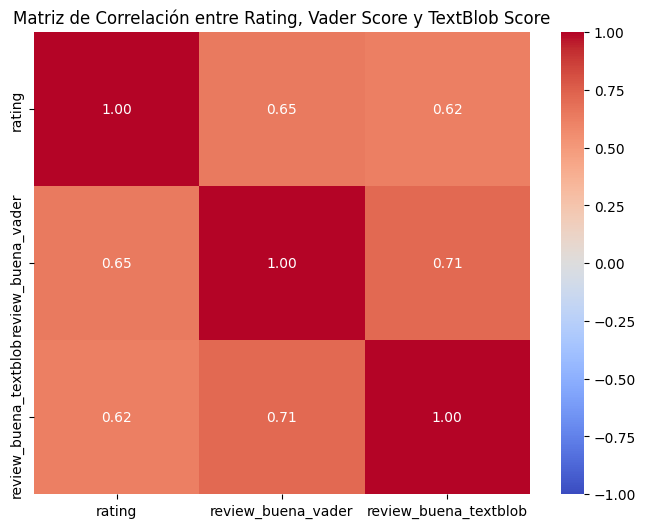

In [9]:
# Calcular la matriz de correlación para las columnas 'rating', 'vader_score' y 'textblob_score'
correlation_matrix = reviews1[['rating', 'review_buena_vader', 'review_buena_textblob']].corr()

# Crear un diagrama de calor para visualizar la matriz de correlación
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Matriz de Correlación entre Rating, Vader Score y TextBlob Score')
plt.show()

Podemos ver que la correlación entre el `raiting` y el la clasificación de "buena" y "mala" para las reviews aumento para ambos metodos de análisis de sentimiento. 

Quedémosnos por ahora con `vader` porque es la que tiene la mayor correlación con el rating

In [10]:
reviews1

,id,rating,has_text,vader_score,textblob_score,date,review_buena_vader,review_buena_textblob
0,gormleysonth297269849815,5,1,0.9576,0.205903,2018-09-17,1,1
1,gormleysonth297269849815,1,1,0.9186,0.497500,2018-09-20,1,1
2,gormleysonth297269849815,5,1,0.6808,0.100000,2018-08-22,1,1
3,gormleysonth297269849815,5,1,0.7906,0.750000,2019-04-17,1,1
4,gormleysonth297269849815,5,1,0.4404,0.700000,2019-05-20,1,1
...,...,...,...,...,...,...,...,...
751912,craftstreetk280493827005,5,1,0.9892,0.518333,2017-08-03,1,1
751913,phokiengiang278518827006,4,1,0.9714,0.632440,2017-12-25,1,1
751914,oecjapanesee277943827291,3,1,0.8773,0.118750,2017-07-14,1,1
751915,craftstreetk280493827005,5,1,0.9806,0.393393,2018-03-20,1,1


In [11]:
# Contamos las reseñas positivas (donde 'review_buena_vader' es 1)
reviews_positivas = reviews1[reviews1['review_buena_vader'] == 1].groupby('id').size().reset_index(name='reviews_positivas')

# Contamos las reseñas negativas (donde 'review_buena_vader' es 0)
reviews_negativas = reviews1[reviews1['review_buena_vader'] == 0].groupby('id').size().reset_index(name='reviews_negativas')

# Unimos los resultados con el DataFrame original en función de 'gmap_id'
reviews1 = reviews1.merge(reviews_positivas, on='id', how='left')
reviews1 = reviews1.merge(reviews_negativas, on='id', how='left')
reviews1["reviews_positivas"]=reviews1["reviews_positivas"].fillna(0)
reviews1["reviews_negativas"]=reviews1["reviews_negativas"].fillna(0)

reviews1 = reviews1.sort_values(by='id', ascending=True)

In [12]:
metadatos_business.shape[0]

26715

In [13]:
metadatos1 = pd.merge(metadatos_business, reviews1[['id','reviews_positivas','reviews_negativas']], on='id', how='left')
metadatos1=metadatos1.drop_duplicates(subset="id",ignore_index=True)
metadatos1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26329 entries, 0 to 26328
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 26329 non-null  object 
 1   name               26329 non-null  object 
 2   street_address     15567 non-null  object 
 3   postal_code        26326 non-null  float64
 4   latitude           26329 non-null  float64
 5   longitude          26329 non-null  float64
 6   city_id            26329 non-null  int64  
 7   category_id        26329 non-null  object 
 8   stars              26329 non-null  float64
 9   review_count       26329 non-null  int64  
 10  is_open            26329 non-null  int64  
 11  address            10421 non-null  object 
 12  reviews_positivas  14431 non-null  float64
 13  reviews_negativas  14431 non-null  float64
dtypes: float64(6), int64(3), object(5)
memory usage: 2.8+ MB


No todos los restaurantes del dataframe de metadata estan en reviews. Esto deja un gran número de entradas vacías en las columnas de `reviews_positivas` y `reviews_negativas`. Lo que haremos es ver la distribución gaussiana que mejor se ajuste a las entradas quu no sean vacías. Luego rellenaremos estas últimas con valores aleatorios siguiendo esas distribuciones. 

In [14]:
def redondeo_columna(df,columna):
    '''Redondea los valores float de la columna a enteros, pero los que se redondean en 0 los cambia por 1'''
    df[columna]=df[columna].round()
    df[columna] = df[columna].replace(0, 1)
    return df

def rellenado_con_distribucion(df,columna):
    '''Rellena los valores nulos de una columna numérica con números positivos aleatorios que sigan la distribución 
       que mejor se ajusta con los valores no nulos'''
    columna_non_null=df[columna].dropna()
    mu, std = norm.fit(columna_non_null)
    lower, upper = 0, np.inf
    truncnorm_dist = truncnorm((lower - mu) / std, (upper - mu) / std, loc=mu, scale=std)
    random_values = truncnorm_dist.rvs(size=df[columna].isnull().sum())
    random_values_series = pd.Series(random_values, index=df[df[columna].isnull()].index)
    df[columna] = df[columna].fillna(random_values_series)
    return df

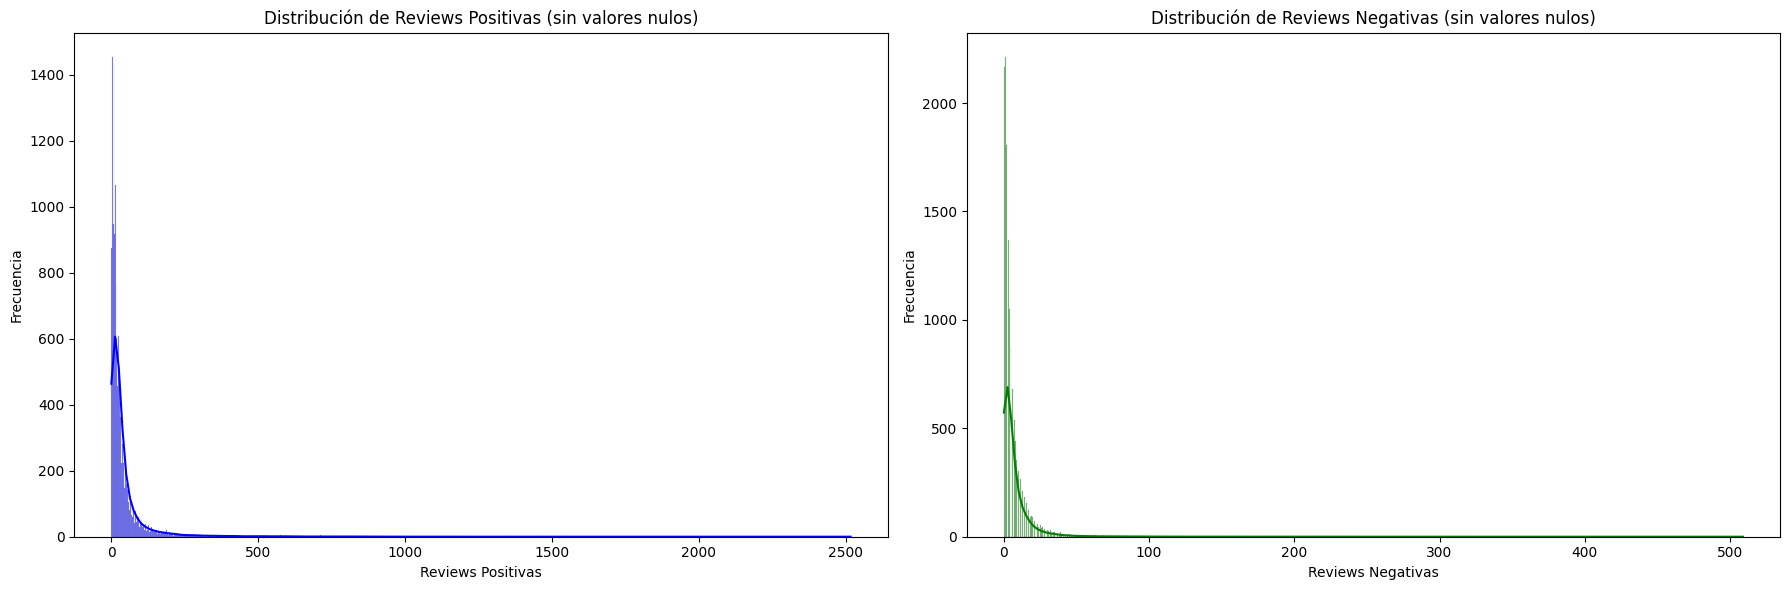

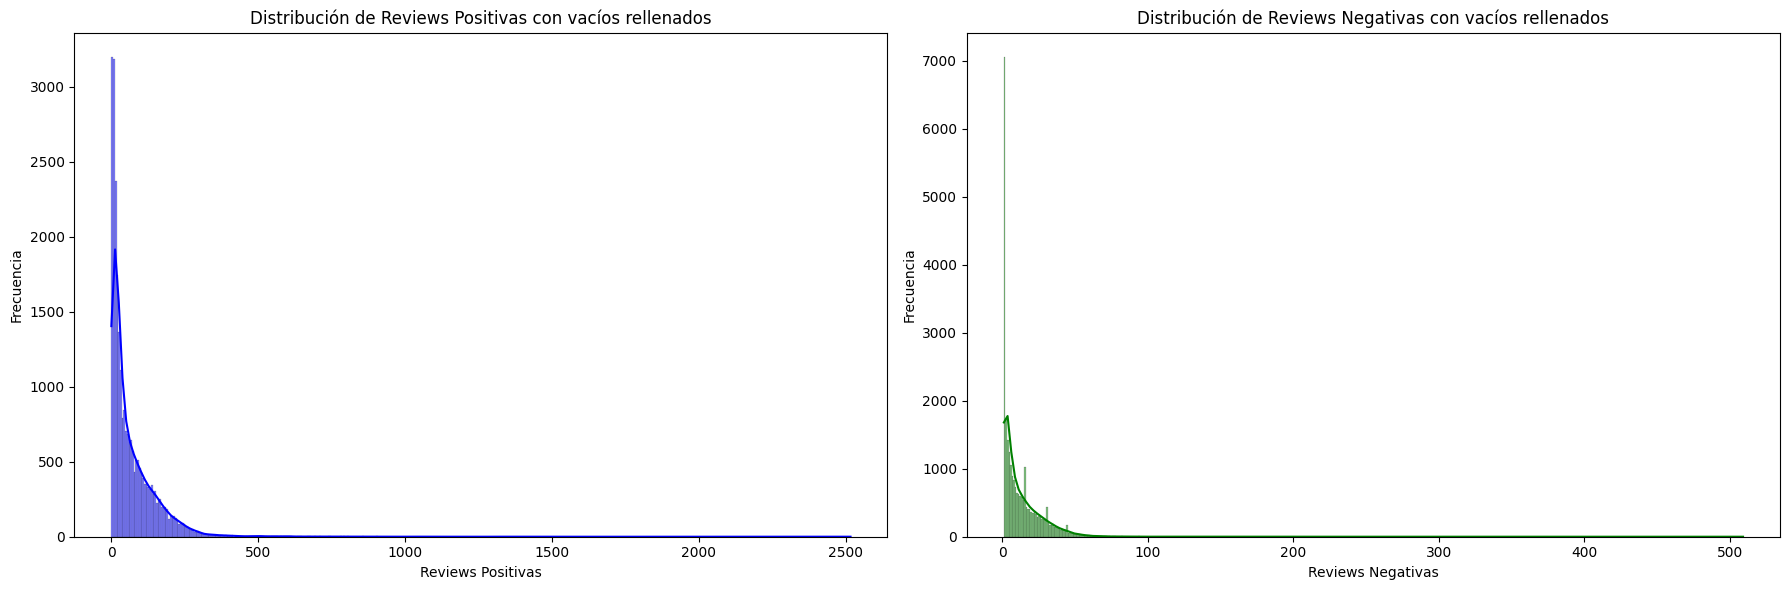

In [15]:
reviews_positivas_non_null = metadatos1['reviews_positivas'].dropna()
reviews_negativas_non_null = metadatos1['reviews_negativas'].dropna()

# Visualizar la distribución de los valores no nulos
fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # 1 fila, 3 columnas

sns.histplot(reviews_positivas_non_null.dropna(), kde=True, ax=axes[0], color='blue')
axes[0].set_title('Distribución de Reviews Positivas (sin valores nulos)')
axes[0].set_xlabel('Reviews Positivas')
axes[0].set_ylabel('Frecuencia')

sns.histplot(reviews_negativas_non_null, kde=True, ax=axes[1], color='green')
axes[1].set_title('Distribución de Reviews Negativas (sin valores nulos)')
axes[1].set_xlabel('Reviews Negativas')
axes[1].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

metadatos1=rellenado_con_distribucion(metadatos1,'reviews_positivas')
metadatos1=rellenado_con_distribucion(metadatos1,'reviews_negativas')
metadatos1=redondeo_columna(metadatos1,['reviews_positivas','reviews_negativas'])

# Visualizar la distribución de los valores
fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # 1 fila, 3 columnas

sns.histplot(metadatos1['reviews_positivas'], kde=True, ax=axes[0], color='blue')
axes[0].set_title('Distribución de Reviews Positivas con vacíos rellenados')
axes[0].set_xlabel('Reviews Positivas')
axes[0].set_ylabel('Frecuencia')

sns.histplot(metadatos1['reviews_negativas'], kde=True, ax=axes[1], color='green')
axes[1].set_title('Distribución de Reviews Negativas con vacíos rellenados')
axes[1].set_xlabel('Reviews Negativas')
axes[1].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

Como se puede ver, las distribuciones resultantes de rellenar las entradas vacías tienen las mismas características de las originales, solo que son mucho más pobladas. Ahora creamos una columna `numero_reviews` que sea la suma de ambas columnas.

In [16]:
metadatos1["numero_reviews"]=metadatos1["reviews_positivas"]+metadatos1["reviews_negativas"]
metadatos1[["reviews_positivas","reviews_negativas","numero_reviews"]]

,reviews_positivas,reviews_negativas,numero_reviews
0,88.0,31.0,119.0
1,51.0,13.0,64.0
2,219.0,26.0,245.0
3,19.0,1.0,20.0
4,14.0,1.0,15.0
...,...,...,...
26324,89.0,17.0,106.0
26325,91.0,9.0,100.0
26326,146.0,13.0,159.0
26327,202.0,14.0,216.0


In [17]:
# Convertimos la columna Population a formato numérico
metadatos1 = metadatos1.merge(ciudades[['city_id','city', 'population']], left_on='city_id', right_on='city_id', how='left')

In [18]:
# Contar el número de restaurantes por ciudad
numero_restaurantes = metadatos1.groupby('city').size()
# Unir el conteo de restaurantes con el DataFrame original
metadatos1['numero_restaurantes'] = metadatos1['city'].map(numero_restaurantes)
metadatos1 = metadatos1.sort_values(by='city', ascending=True)
metadatos1=metadatos1.reset_index(drop=True)

In [19]:
metadatos1.columns

Index(['id', 'name', 'street_address', 'postal_code', 'latitude', 'longitude',
       'city_id', 'category_id', 'stars', 'review_count', 'is_open', 'address',
       'reviews_positivas', 'reviews_negativas', 'numero_reviews', 'city',
       'population', 'numero_restaurantes'],
      dtype='object')

In [20]:
metadatos1.to_csv('metadatos_ML.csv',index=False)

In [21]:
'''# Codificar las categorías y ciudades (Label Encoding)
label_encoder_city = LabelEncoder()
metadatos1['city_encoded'] = label_encoder_city.fit_transform(metadatos1['city'])

label_encoder_category = LabelEncoder()
metadatos1['category_encoded'] = label_encoder_category.fit_transform(metadatos1['categories'])'''

"# Codificar las categorías y ciudades (Label Encoding)\nlabel_encoder_city = LabelEncoder()\nmetadatos1['city_encoded'] = label_encoder_city.fit_transform(metadatos1['city'])\n\nlabel_encoder_category = LabelEncoder()\nmetadatos1['category_encoded'] = label_encoder_category.fit_transform(metadatos1['categories'])"

In [91]:
def Phi_categoría(id_categoria,df):

    # Filtramos por categorias
    df_filtrado=df[df['category_id'].apply(lambda x: id_categoria in x)]
    # Calculamos columnas para la fórmula 
    df_filtrado["P_h"]=(df_filtrado["population"]/df_filtrado["numero_restaurantes"])
    df_filtrado["P_{r,i}"]=(df_filtrado['reviews_positivas']/df_filtrado['reviews_negativas'])*df_filtrado['numero_reviews']
    df_filtrado["P_{c,i}"]=df_filtrado['stars']*df_filtrado['numero_reviews']
    df_filtrado['suma P_{r,i}'] = df_filtrado.groupby('city')["P_{r,i}"].transform('sum')
    df_filtrado['1/P_r'] = (df_filtrado['suma P_{r,i}']/df_filtrado['numero_restaurantes'])**(-1)
    df_filtrado['suma P_{c,i}'] = df_filtrado.groupby('city')["P_{c,i}"].transform('sum')
    df_filtrado['1/P_c'] = (df_filtrado['suma P_{c,i}']/df_filtrado['numero_restaurantes'])**(-1)
    # Escalamos las columnas para que queden en un rango entre 0 y 1
    variables_para_escalar=["P_h",'1/P_r','1/P_c']
    '''scaler = RobustScaler()
    df_filtrado[["P_h"]] = scaler.fit_transform(df_filtrado[["P_h"]])
    df_filtrado[['1/P_r','1/P_c']] = np.log1p(np.log1p(df_filtrado[['1/P_r','1/P_c']]))'''
    df_filtrado[['1/P_r']] = np.log1p(np.log1p(df_filtrado[['1/P_r']]))
    scaler = MinMaxScaler()
    df_filtrado[variables_para_escalar] = scaler.fit_transform(df_filtrado[variables_para_escalar])
    # Creamos la columna con el coeficiente Phi
    a=1
    b=2
    c=2.5
    df_filtrado["Phi"]=a*df_filtrado["P_h"]+b*df_filtrado["1/P_r"]+c*df_filtrado["1/P_c"]
    # Eliminamos los duplicados en las ciudades para que tengamos solo datos de ciudades
    df_final=df_filtrado.drop_duplicates(subset="city",ignore_index=True)
    
    return df_final

    

Acá armo los datos de entrenamiento y los de testeo. El tema de las categorías hay que corregirlo. Hay demaciadas categorias y hay algunas que tienen 1 restaurante. Eso no puede quedar así para el futuro. Paula está en eso 

In [92]:
metadatos1['category_id']=metadatos1['category_id'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
categorias_list=[i for i in range(1,categorias.shape[0]+1)]
dfs_categorias = [Phi_categoría(categoria,metadatos1) for categoria in categorias_list]
for i in range(1,len(dfs_categorias)+1):
    dfs_categorias[i-1]['category_id']=i

X=[dfs_categorias[i][['city_id', 'category_id']] for i in range(len(dfs_categorias))]
y=[dfs_categorias[i]['Phi'] for i in range(len(dfs_categorias))]

# Filtrar los dataframes que tienen más de una muestra
X_train_list, X_test_list, y_train_list, y_test_list = [], [], [], []

for i in range(len(dfs_categorias)):
    if len(X[i]) > 1:  # Solo dividir si hay más de 1 muestra
        X_temp, X_temp_test, y_temp, y_temp_test = train_test_split(X[i], y[i], test_size=0.2, random_state=42)
        X_train_list.append(X_temp)
        X_test_list.append(X_temp_test)
        y_train_list.append(y_temp)
        y_test_list.append(y_temp_test)
    else:
        print(f"Categoria '{categorias[i]}' tiene solo una muestra. No se puede dividir.")

X_train=pd.concat([df for df in X_train_list],axis=0, ignore_index=True)
X_test=pd.concat([df for df in X_test_list],axis=0, ignore_index=True)
y_train=pd.concat([df for df in y_train_list],axis=0, ignore_index=True)
y_test=pd.concat([df for df in y_test_list],axis=0, ignore_index=True)


C:\Users\maria\AppData\Local\Temp\ipykernel_25208\4062725084.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado["P_h"]=(df_filtrado["population"]/df_filtrado["numero_restaurantes"])
C:\Users\maria\AppData\Local\Temp\ipykernel_25208\4062725084.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado["P_{r,i}"]=(df_filtrado['reviews_positivas']/df_filtrado['reviews_negativas'])*df_filtrado['numero_reviews']
C:\Users\maria\AppData\Local\Temp\ipykernel_25208\4062725084.py:8: SettingWithCopyW

Cambio el `numero de neuronas por capas` para ver como cambia el Root Mean Squared Error

c:\Users\maria\Documents\Ezequiel\Eze\HENRY\ENTORNO_VIRTUAL\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - loss: 207.2467 - val_loss: 1.9897
Epoch 2/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 13.7038 - val_loss: 0.9224
Epoch 3/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 6.5227 - val_loss: 0.4206
Epoch 4/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 3.6319 - val_loss: 0.3295
Epoch 5/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 2.7119 - val_loss: 0.2438
Epoch 6/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 1.5842 - val_loss: 0.1603
Epoch 7/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 1.2149 - val_loss: 0.1187
Epoch 8/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.9410 - val_loss: 0.1028
Epoch 9/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - loss: 0.6628 - val_loss: 0.0852
Epoch 10/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.5217 - val_loss: 0.0816
Epoch 11/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.4951 - val_loss: 0.0775
Epoch 12/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms

c:\Users\maria\Documents\Ezequiel\Eze\HENRY\ENTORNO_VIRTUAL\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - loss: 141.5035 - val_loss: 0.1188
Epoch 2/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 7.4137 - val_loss: 0.2563
Epoch 3/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 2.4751 - val_loss: 0.1548
Epoch 4/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 1.2073 - val_loss: 0.0966
Epoch 5/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.6139 - val_loss: 0.0728
Epoch 6/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.2689 - val_loss: 0.0754
Epoch 7/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1333 - val_loss: 0.0731
Epoch 8/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0891 - val_loss: 0.0736
Epoch 9/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0806 - val_loss: 0.0742
Epoch 10/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0847 - val_loss: 0.0738
Epoch 11/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0819 - val_loss: 0.0735
Epoch 12/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/s

c:\Users\maria\Documents\Ezequiel\Eze\HENRY\ENTORNO_VIRTUAL\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - loss: 42.2906 - val_loss: 0.4810
Epoch 2/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 1.0085 - val_loss: 0.1115
Epoch 3/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.2754 - val_loss: 0.0826
Epoch 4/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.1626 - val_loss: 0.0815
Epoch 5/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.1203 - val_loss: 0.0781
Epoch 6/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0866 - val_loss: 0.0731
Epoch 7/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0823 - val_loss: 0.0736
Epoch 8/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0787 - val_loss: 0.0731
Epoch 9/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0872 - val_loss: 0.0734
Epoch 10/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0781 - val_loss: 0.0739
Epoch 11/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0766 - val_loss: 0.0773
Epoch 12/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/st

c:\Users\maria\Documents\Ezequiel\Eze\HENRY\ENTORNO_VIRTUAL\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - loss: 24.1983 - val_loss: 0.0955
Epoch 2/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.5154 - val_loss: 0.0795
Epoch 3/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.2312 - val_loss: 0.0787
Epoch 4/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.1504 - val_loss: 0.0746
Epoch 5/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.1128 - val_loss: 0.0761
Epoch 6/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0963 - val_loss: 0.0728
Epoch 7/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0965 - val_loss: 0.0713
Epoch 8/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - loss: 0.0855 - val_loss: 0.0715
Epoch 9/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0870 - val_loss: 0.0722
Epoch 10/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0863 - val_loss: 0.0720
Epoch 11/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0809 - val_loss: 0.0716
Epoch 12/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/st

c:\Users\maria\Documents\Ezequiel\Eze\HENRY\ENTORNO_VIRTUAL\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 24.2247 - val_loss: 0.1650
Epoch 2/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.3887 - val_loss: 0.0963
Epoch 3/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.1650 - val_loss: 0.0795
Epoch 4/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.1059 - val_loss: 0.0748
Epoch 5/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0861 - val_loss: 0.0740
Epoch 6/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0837 - val_loss: 0.0766
Epoch 7/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0876 - val_loss: 0.0709
Epoch 8/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0868 - val_loss: 0.0720
Epoch 9/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0844 - val_loss: 0.0728
Epoch 10/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0888 - val_loss: 0.0727
Epoch 11/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0854 - val_loss: 0.0729
Epoch 12/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/ste

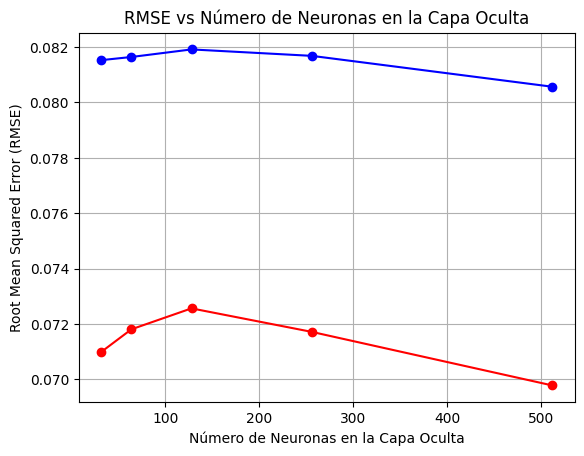

   Neuronas:      RMSE
0         32  0.081530
1         64  0.081644
2        128  0.081917
3        256  0.081685
4        512  0.080570


In [ ]:
# Lista para almacenar los RMSE calculados
rmse_train_values = []
rmse_test_values = []
neurons_range = [32, 64, 128, 256, 512] 
for i in  neurons_range:
    # Crear el modelo
    model = Sequential()
    # Capa de entrada
    model.add(Dense(i, input_dim=X_train.shape[1], activation='relu'))
    # Capa oculta
    model.add(Dense(int(i/2), activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(int(i/2), activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(int(i/2), activation='relu'))
    # Capa de salida (un solo valor para el coeficiente phi)
    model.add(Dense(1, activation='linear'))
    # Compilar el modelo
    model.compile(optimizer='Nadam', loss='mean_squared_error')
    # Entrenar el modelo
    history = model.fit(X_train, y_train, epochs=150, batch_size=50, validation_data=(X_test, y_test))
    # Realizar predicciones
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    # Asegúrate de que ambos son vectores 1D
    if len(y_pred_train.shape) > 1:
        y_pred_train = y_pred_train.flatten()

    if len(y_train.shape) > 1:
        y_train = y_train.flatten()

    if len(y_pred_train.shape) > 1:
        y_pred_train = y_pred_test.flatten()

    if len(y_test.shape) > 1:
        y_test = y_test.flatten()

    mse_train = mean_squared_error(y_train, y_pred_train)
    rmse_train = np.sqrt(mse_train)
    mse_test = mean_squared_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mse_test)

    rmse_train_values.append(mse_train)
    rmse_test_values.append(mse_test)
# Graficar los resultados
plt.plot(neurons_range, rmse_train_values, marker='o', color='b', label='Entrenamiento')
plt.plot(neurons_range, rmse_test_values, marker='o', color='r', label='Prueba')
plt.title('RMSE vs Número de Neuronas en la Capa Oculta')
plt.xlabel('Número de Neuronas en la Capa Oculta')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.grid(True)
plt.show()

print(pd.DataFrame({"Neuronas:":neurons_range,
                    "RMSE":rmse_test_values}))



Me quedo con 512 en capa de entrada y 256 en las ocultas

Cambio el `numero de epochs` para ver como cambia el Root Mean Squared Error

c:\Users\maria\Documents\Ezequiel\Eze\HENRY\ENTORNO_VIRTUAL\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
95/95 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 67.1247 - val_loss: 0.1779
Epoch 2/5
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.6196 - val_loss: 0.0902
Epoch 3/5
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.2784 - val_loss: 0.0786
Epoch 4/5
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.1330 - val_loss: 0.0753
Epoch 5/5
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0945 - val_loss: 0.0744
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/10


c:\Users\maria\Documents\Ezequiel\Eze\HENRY\ENTORNO_VIRTUAL\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 38.9966 - val_loss: 0.2987
Epoch 2/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.4922 - val_loss: 0.0877
Epoch 3/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.2387 - val_loss: 0.0843
Epoch 4/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.1285 - val_loss: 0.0752
Epoch 5/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.1174 - val_loss: 0.0753
Epoch 6/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0894 - val_loss: 0.0759
Epoch 7/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0843 - val_loss: 0.0720
Epoch 8/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0835 - val_loss: 0.0706
Epoch 9/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0751 - val_loss: 0.0717
Epoch 10/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0813 - val_loss: 0.0728
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/15


c:\Users\maria\Documents\Ezequiel\Eze\HENRY\ENTORNO_VIRTUAL\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 32.9475 - val_loss: 0.2628
Epoch 2/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.4471 - val_loss: 0.1085
Epoch 3/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1992 - val_loss: 0.0811
Epoch 4/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1223 - val_loss: 0.0746
Epoch 5/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0944 - val_loss: 0.0732
Epoch 6/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0792 - val_loss: 0.0719
Epoch 7/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0829 - val_loss: 0.0715
Epoch 8/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0829 - val_loss: 0.0739
Epoch 9/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0787 - val_loss: 0.0720
Epoch 10/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0873 - val_loss: 0.0710
Epoch 11/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0887 - val_loss: 0.0712
Epoch 12/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0825 - val_

c:\Users\maria\Documents\Ezequiel\Eze\HENRY\ENTORNO_VIRTUAL\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 54.8737 - val_loss: 0.1581
Epoch 2/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.6180 - val_loss: 0.1258
Epoch 3/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.2906 - val_loss: 0.0830
Epoch 4/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1393 - val_loss: 0.0762
Epoch 5/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1037 - val_loss: 0.0730
Epoch 6/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0839 - val_loss: 0.0715
Epoch 7/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0766 - val_loss: 0.0713
Epoch 8/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0831 - val_loss: 0.0712
Epoch 9/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0936 - val_loss: 0.0717
Epoch 10/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0794 - val_loss: 0.0738
Epoch 11/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0797 - val_loss: 0.0729
Epoch 12/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.

c:\Users\maria\Documents\Ezequiel\Eze\HENRY\ENTORNO_VIRTUAL\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 42.5970 - val_loss: 0.1438
Epoch 2/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.5838 - val_loss: 0.0905
Epoch 3/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.2052 - val_loss: 0.0926
Epoch 4/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1240 - val_loss: 0.0755
Epoch 5/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1090 - val_loss: 0.0735
Epoch 6/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0842 - val_loss: 0.0718
Epoch 7/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0814 - val_loss: 0.0737
Epoch 8/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0786 - val_loss: 0.0728
Epoch 9/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0850 - val_loss: 0.0726
Epoch 10/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0785 - val_loss: 0.0737
Epoch 11/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0818 - val_loss: 0.0713
Epoch 12/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0826 - val_

c:\Users\maria\Documents\Ezequiel\Eze\HENRY\ENTORNO_VIRTUAL\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 90.8803 - val_loss: 0.1432
Epoch 2/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.7314 - val_loss: 0.0841
Epoch 3/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.3833 - val_loss: 0.1106
Epoch 4/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.2398 - val_loss: 0.0751
Epoch 5/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.1421 - val_loss: 0.0746
Epoch 6/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0964 - val_loss: 0.0732
Epoch 7/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0957 - val_loss: 0.0741
Epoch 8/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0913 - val_loss: 0.0733
Epoch 9/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0795 - val_loss: 0.0731
Epoch 10/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0798 - val_loss: 0.0745
Epoch 11/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0795 - val_loss: 0.0739
Epoch 12/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.

c:\Users\maria\Documents\Ezequiel\Eze\HENRY\ENTORNO_VIRTUAL\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 30.3025 - val_loss: 0.1624
Epoch 2/75
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.4316 - val_loss: 0.1074
Epoch 3/75
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1968 - val_loss: 0.0888
Epoch 4/75
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.1373 - val_loss: 0.0743
Epoch 5/75
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0957 - val_loss: 0.0742
Epoch 6/75
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0971 - val_loss: 0.0715
Epoch 7/75
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0903 - val_loss: 0.0712
Epoch 8/75
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0892 - val_loss: 0.0717
Epoch 9/75
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0881 - val_loss: 0.0703
Epoch 10/75
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0911 - val_loss: 0.0704
Epoch 11/75
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0853 - val_loss: 0.0701
Epoch 12/75
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0828 - val_

c:\Users\maria\Documents\Ezequiel\Eze\HENRY\ENTORNO_VIRTUAL\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 43.1038 - val_loss: 0.3534
Epoch 2/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.4288 - val_loss: 0.0920
Epoch 3/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.2304 - val_loss: 0.1008
Epoch 4/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1500 - val_loss: 0.0779
Epoch 5/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1187 - val_loss: 0.0772
Epoch 6/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1005 - val_loss: 0.0745
Epoch 7/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0900 - val_loss: 0.0720
Epoch 8/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0811 - val_loss: 0.0721
Epoch 9/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0764 - val_loss: 0.0722
Epoch 10/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0810 - val_loss: 0.0704
Epoch 11/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0820 - val_loss: 0.0721
Epoch 12/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.

c:\Users\maria\Documents\Ezequiel\Eze\HENRY\ENTORNO_VIRTUAL\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/125
95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 46.6864 - val_loss: 0.0950
Epoch 2/125
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.5499 - val_loss: 0.0873
Epoch 3/125
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.2471 - val_loss: 0.1005
Epoch 4/125
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1275 - val_loss: 0.0760
Epoch 5/125
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1022 - val_loss: 0.0739
Epoch 6/125
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0967 - val_loss: 0.0726
Epoch 7/125
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0831 - val_loss: 0.0742
Epoch 8/125
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0870 - val_loss: 0.0731
Epoch 9/125
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0805 - val_loss: 0.0707
Epoch 10/125
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0796 - val_loss: 0.0716
Epoch 11/125
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0829 - val_loss: 0.0716
Epoch 12/125
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/ste

c:\Users\maria\Documents\Ezequiel\Eze\HENRY\ENTORNO_VIRTUAL\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 25.8752 - val_loss: 0.1154
Epoch 2/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.3786 - val_loss: 0.0854
Epoch 3/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.2006 - val_loss: 0.0806
Epoch 4/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1138 - val_loss: 0.0754
Epoch 5/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0997 - val_loss: 0.0782
Epoch 6/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0915 - val_loss: 0.0713
Epoch 7/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0886 - val_loss: 0.0737
Epoch 8/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0742 - val_loss: 0.0717
Epoch 9/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0788 - val_loss: 0.0716
Epoch 10/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0853 - val_loss: 0.0711
Epoch 11/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0795 - val_loss: 0.0709
Epoch 12/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.

c:\Users\maria\Documents\Ezequiel\Eze\HENRY\ENTORNO_VIRTUAL\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


95/95 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - loss: 36.6833 - val_loss: 0.0874
Epoch 2/175
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.4179 - val_loss: 0.0824
Epoch 3/175
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1720 - val_loss: 0.0754
Epoch 4/175
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1145 - val_loss: 0.0746
Epoch 5/175
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0930 - val_loss: 0.0724
Epoch 6/175
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0814 - val_loss: 0.0717
Epoch 7/175
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0859 - val_loss: 0.0740
Epoch 8/175
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0909 - val_loss: 0.0715
Epoch 9/175
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0814 - val_loss: 0.0709
Epoch 10/175
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0786 - val_loss: 0.0755
Epoch 11/175
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0863 - val_loss: 0.0737
Epoch 12/175
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0

c:\Users\maria\Documents\Ezequiel\Eze\HENRY\ENTORNO_VIRTUAL\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 27.0702 - val_loss: 0.1094
Epoch 2/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.4960 - val_loss: 0.0919
Epoch 3/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.2048 - val_loss: 0.0871
Epoch 4/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1177 - val_loss: 0.0823
Epoch 5/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0927 - val_loss: 0.0734
Epoch 6/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0800 - val_loss: 0.0723
Epoch 7/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0885 - val_loss: 0.0722
Epoch 8/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0772 - val_loss: 0.0710
Epoch 9/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0840 - val_loss: 0.0718
Epoch 10/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0826 - val_loss: 0.0711
Epoch 11/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0801 - val_loss: 0.0715
Epoch 12/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/ste

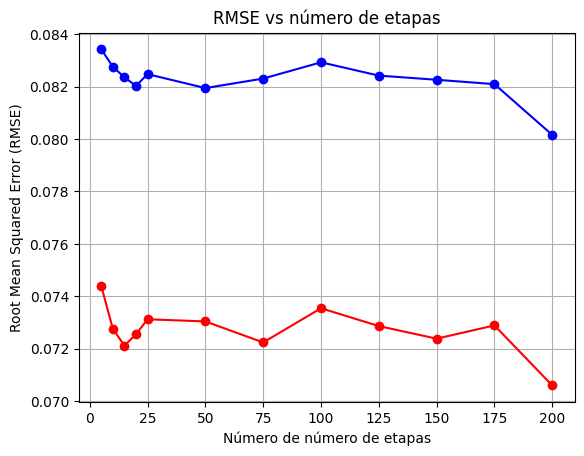

    número de etapas:      RMSE
0                   5  0.074379
1                  10  0.072756
2                  15  0.072116
3                  20  0.072552
4                  25  0.073122
5                  50  0.073040
6                  75  0.072238
7                 100  0.073543
8                 125  0.072864
9                 150  0.072382
10                175  0.072888
11                200  0.070599


In [31]:
# Lista para almacenar los RMSE calculados
rmse_train_values = []
rmse_test_values = []
nuemero_etapas = [5,10,15,20,25, 50, 75, 100, 125, 150, 175,200] 
for i in  nuemero_etapas:
    # Crear el modelo
    model = Sequential()
    # Capa de entrada
    model.add(Dense(512, input_dim=X_train.shape[1], activation='relu'))
    # Capa oculta
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    # Capa de salida (un solo valor para el coeficiente phi)
    model.add(Dense(1, activation='linear'))
    # Compilar el modelo
    model.compile(optimizer='Nadam', loss='mean_squared_error')
    # Entrenar el modelo
    history = model.fit(X_train, y_train, epochs=i, batch_size=50, validation_data=(X_test, y_test))
    # Realizar predicciones
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    # Asegúrate de que ambos son vectores 1D
    if len(y_pred_train.shape) > 1:
        y_pred_train = y_pred_train.flatten()

    if len(y_train.shape) > 1:
        y_train = y_train.flatten()

    if len(y_pred_train.shape) > 1:
        y_pred_train = y_pred_test.flatten()

    if len(y_test.shape) > 1:
        y_test = y_test.flatten()

    mse_train = mean_squared_error(y_train, y_pred_train)
    rmse_train = np.sqrt(mse_train)
    mse_test = mean_squared_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mse_test)

    rmse_train_values.append(mse_train)
    rmse_test_values.append(mse_test)

# Graficar los resultados
plt.plot(nuemero_etapas, rmse_train_values, marker='o', color='b', label='Entrenamiento')
plt.plot(nuemero_etapas, rmse_test_values, marker='o', color='r', label='Prueba')
plt.title('RMSE vs número de etapas')
plt.xlabel('Número de número de etapas')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.grid(True)
plt.show()

print(pd.DataFrame({"número de etapas:":nuemero_etapas,
                    "RMSE":rmse_test_values}))

Me quedo con 200

Cambio el `batch_size` para ver como cambia el Root Mean Squared Error

c:\Users\maria\Documents\Ezequiel\Eze\HENRY\ENTORNO_VIRTUAL\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
949/949 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 20.7440 - val_loss: 0.0814
Epoch 2/200
949/949 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0964 - val_loss: 0.0734
Epoch 3/200
949/949 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0983 - val_loss: 0.0747
Epoch 4/200
949/949 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0822 - val_loss: 0.0734
Epoch 5/200
949/949 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0733 - val_loss: 0.0730
Epoch 6/200
949/949 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0774 - val_loss: 0.0746
Epoch 7/200
949/949 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0800 - val_loss: 0.0748
Epoch 8/200
949/949 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0939 - val_loss: 0.0753
Epoch 9/200
949/949 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0816 - val_loss: 0.0756
Epoch 10/200
949/949 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.0851 - val_loss: 0.0750
Epoch 11/200
949/949 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0918 - val_loss: 0.0747
Epoch 12/200
949/949 ━━━━━━━━━━━━━━━━━━━

c:\Users\maria\Documents\Ezequiel\Eze\HENRY\ENTORNO_VIRTUAL\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


475/475 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 17.1269 - val_loss: 0.0773
Epoch 2/200
475/475 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1415 - val_loss: 0.0715
Epoch 3/200
475/475 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0941 - val_loss: 0.0726
Epoch 4/200
475/475 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0733 - val_loss: 0.0746
Epoch 5/200
475/475 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0858 - val_loss: 0.0729
Epoch 6/200
475/475 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0851 - val_loss: 0.0727
Epoch 7/200
475/475 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0825 - val_loss: 0.0733
Epoch 8/200
475/475 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0870 - val_loss: 0.0730
Epoch 9/200
475/475 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0846 - val_loss: 0.0736
Epoch 10/200
475/475 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0851 - val_loss: 0.0733
Epoch 11/200
475/475 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0861 - val_loss: 0.0744
Epoch 12/200
475/475 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/ste

c:\Users\maria\Documents\Ezequiel\Eze\HENRY\ENTORNO_VIRTUAL\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


317/317 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 62.0144 - val_loss: 0.1128
Epoch 2/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5845 - val_loss: 0.0828
Epoch 3/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1309 - val_loss: 0.0742
Epoch 4/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0989 - val_loss: 0.0730
Epoch 5/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0843 - val_loss: 0.0722
Epoch 6/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0796 - val_loss: 0.0733
Epoch 7/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0764 - val_loss: 0.0726
Epoch 8/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0800 - val_loss: 0.0726
Epoch 9/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0849 - val_loss: 0.0724
Epoch 10/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0778 - val_loss: 0.0723
Epoch 11/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0838 - val_loss: 0.0728
Epoch 12/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/ste

c:\Users\maria\Documents\Ezequiel\Eze\HENRY\ENTORNO_VIRTUAL\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 37.4196 - val_loss: 0.0978
Epoch 2/200
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.5947 - val_loss: 0.0981
Epoch 3/200
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2296 - val_loss: 0.0792
Epoch 4/200
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1150 - val_loss: 0.0754
Epoch 5/200
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0986 - val_loss: 0.0720
Epoch 6/200
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0875 - val_loss: 0.0710
Epoch 7/200
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0816 - val_loss: 0.0713
Epoch 8/200
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0820 - val_loss: 0.0723
Epoch 9/200
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0815 - val_loss: 0.0705
Epoch 10/200
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0814 - val_loss: 0.0707
Epoch 11/200
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0853 - val_loss: 0.0712
Epoch 12/200
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/ste

c:\Users\maria\Documents\Ezequiel\Eze\HENRY\ENTORNO_VIRTUAL\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


190/190 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 42.2672 - val_loss: 0.1346
Epoch 2/200
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.8522 - val_loss: 0.0826
Epoch 3/200
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1825 - val_loss: 0.0755
Epoch 4/200
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1178 - val_loss: 0.0758
Epoch 5/200
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0963 - val_loss: 0.0753
Epoch 6/200
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0856 - val_loss: 0.0725
Epoch 7/200
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0835 - val_loss: 0.0722
Epoch 8/200
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0849 - val_loss: 0.0737
Epoch 9/200
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0964 - val_loss: 0.0722
Epoch 10/200
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0820 - val_loss: 0.0719
Epoch 11/200
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0801 - val_loss: 0.0718
Epoch 12/200
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/ste

c:\Users\maria\Documents\Ezequiel\Eze\HENRY\ENTORNO_VIRTUAL\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 35.3238 - val_loss: 0.1099
Epoch 2/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7987 - val_loss: 0.0927
Epoch 3/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6456 - val_loss: 0.0876
Epoch 4/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3171 - val_loss: 0.0785
Epoch 5/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2059 - val_loss: 0.0784
Epoch 6/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1237 - val_loss: 0.0743
Epoch 7/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1067 - val_loss: 0.0728
Epoch 8/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0916 - val_loss: 0.0721
Epoch 9/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0800 - val_loss: 0.0715
Epoch 10/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0802 - val_loss: 0.0712
Epoch 11/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0746 - val_loss: 0.0716
Epoch 12/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0853 - val_l

c:\Users\maria\Documents\Ezequiel\Eze\HENRY\ENTORNO_VIRTUAL\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 59.7384 - val_loss: 0.1272
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.1262 - val_loss: 0.1432
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7163 - val_loss: 0.1177
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4416 - val_loss: 0.0770
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2651 - val_loss: 0.0757
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2107 - val_loss: 0.0755
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1757 - val_loss: 0.0741
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1664 - val_loss: 0.0732
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1218 - val_loss: 0.0724
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1236 - val_loss: 0.0721
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1082 - val_loss: 0.0728
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1023 - val_

c:\Users\maria\Documents\Ezequiel\Eze\HENRY\ENTORNO_VIRTUAL\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 105.4401 - val_loss: 0.1456
Epoch 2/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.2634 - val_loss: 0.1058
Epoch 3/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.5141 - val_loss: 0.1415
Epoch 4/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9261 - val_loss: 0.0843
Epoch 5/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5959 - val_loss: 0.1018
Epoch 6/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4447 - val_loss: 0.0847
Epoch 7/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3250 - val_loss: 0.0858
Epoch 8/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2577 - val_loss: 0.0773
Epoch 9/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2333 - val_loss: 0.0765
Epoch 10/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1848 - val_loss: 0.0740
Epoch 11/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1590 - val_loss: 0.0761
Epoch 12/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 

c:\Users\maria\Documents\Ezequiel\Eze\HENRY\ENTORNO_VIRTUAL\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 220.9115 - val_loss: 0.2303
Epoch 2/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.2927 - val_loss: 0.1124
Epoch 3/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.3054 - val_loss: 0.1008
Epoch 4/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9408 - val_loss: 0.0929
Epoch 5/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2423 - val_loss: 0.1246
Epoch 6/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9699 - val_loss: 0.0848
Epoch 7/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6417 - val_loss: 0.0868
Epoch 8/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4818 - val_loss: 0.0887
Epoch 9/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3274 - val_loss: 0.0838
Epoch 10/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2336 - val_loss: 0.0813
Epoch 11/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1450 - val_loss: 0.0806
Epoch 12/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1320 - v

c:\Users\maria\Documents\Ezequiel\Eze\HENRY\ENTORNO_VIRTUAL\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 277.3543 - val_loss: 0.3068
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.0644 - val_loss: 0.5318
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.2989 - val_loss: 0.1465
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9433 - val_loss: 0.1014
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5932 - val_loss: 0.1051
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1815 - val_loss: 0.0937
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9248 - val_loss: 0.0909
Epoch 8/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8844 - val_loss: 0.1182
Epoch 9/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6454 - val_loss: 0.1092
Epoch 10/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6377 - val_loss: 0.0830
Epoch 11/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5150 - val_loss: 0.0897
Epoch 12/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.4183 -

c:\Users\maria\Documents\Ezequiel\Eze\HENRY\ENTORNO_VIRTUAL\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 45.4537 - val_loss: 0.1986
Epoch 2/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.4808 - val_loss: 0.2742
Epoch 3/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4780 - val_loss: 0.2086
Epoch 4/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8907 - val_loss: 0.0994
Epoch 5/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5432 - val_loss: 0.0889
Epoch 6/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4363 - val_loss: 0.0880
Epoch 7/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2794 - val_loss: 0.0802
Epoch 8/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2300 - val_loss: 0.0781
Epoch 9/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2027 - val_loss: 0.0781
Epoch 10/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1498 - val_loss: 0.0804
Epoch 11/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1378 - val_loss: 0.0773
Epoch 12/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1167 - 

c:\Users\maria\Documents\Ezequiel\Eze\HENRY\ENTORNO_VIRTUAL\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 46.1427 - val_loss: 1.7971
Epoch 2/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.7333 - val_loss: 0.3690
Epoch 3/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.6674 - val_loss: 0.1623
Epoch 4/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0107 - val_loss: 0.0910
Epoch 5/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5904 - val_loss: 0.0837
Epoch 6/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3720 - val_loss: 0.0843
Epoch 7/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2816 - val_loss: 0.0810
Epoch 8/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2116 - val_loss: 0.0850
Epoch 9/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1728 - val_loss: 0.0816
Epoch 10/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1341 - val_loss: 0.0810
Epoch 11/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1223 - val_loss: 0.0798
Epoch 12/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1161 -

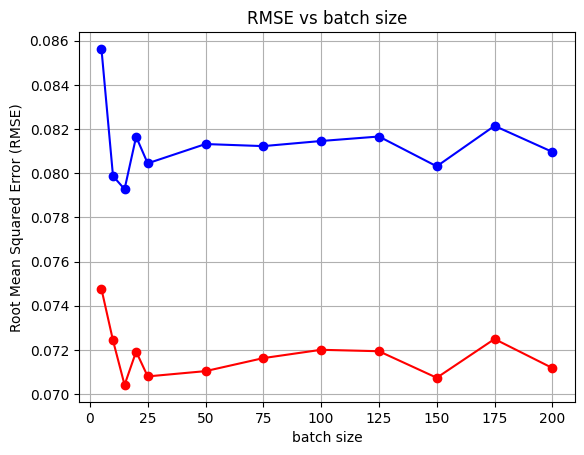

    batch size:      RMSE
0             5  0.074760
1            10  0.072428
2            15  0.070417
3            20  0.071927
4            25  0.070802
5            50  0.071041
6            75  0.071631
7           100  0.072007
8           125  0.071942
9           150  0.070741
10          175  0.072496
11          200  0.071182


In [ ]:
# Lista para almacenar los RMSE calculados
rmse_train_values = []
rmse_test_values = []
batch_size = [5,10,15,20,25, 50, 75, 100, 125, 150, 175,200] 
for i in  batch_size:
    # Crear el modelo
    model = Sequential()

    # Capa de entrada
    model.add(Dense(512, input_dim=X_train.shape[1], activation='relu'))
    # Capa oculta
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))

    # Capa de salida (un solo valor para el coeficiente phi)
    model.add(Dense(1, activation='linear'))

    # Compilar el modelo
    #model.compile(optimizer='adam', loss='mean_squared_error')
    #model.compile(optimizer='RMSprop', loss='mean_squared_error')
    model.compile(optimizer='Nadam', loss='mean_squared_error')

    # Entrenar el modelo
    history = model.fit(X_train, y_train, epochs=200, batch_size=i, validation_data=(X_test, y_test))

    # Realizar predicciones
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)


    # Asegúrate de que ambos son vectores 1D
    if len(y_pred_train.shape) > 1:
        y_pred_train = y_pred_train.flatten()

    if len(y_train.shape) > 1:
        y_train = y_train.flatten()

    if len(y_pred_train.shape) > 1:
        y_pred_train = y_pred_test.flatten()

    if len(y_test.shape) > 1:
        y_test = y_test.flatten()

    mse_train = mean_squared_error(y_train, y_pred_train)
    rmse_train = np.sqrt(mse_train)
    mse_test = mean_squared_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mse_test)

    rmse_train_values.append(mse_train)
    rmse_test_values.append(mse_test)

# Graficar los resultados
plt.plot(batch_size, rmse_train_values, marker='o', color='b', label='Entrenamiento')
plt.plot(batch_size, rmse_test_values, marker='o', color='r', label='Prueba')
plt.title('RMSE vs batch size')
plt.xlabel('batch size')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.grid(True)
plt.show()

print(pd.DataFrame({"batch size:":batch_size,
                    "RMSE":rmse_test_values}))


Me quedo con el 150

Cambio el `optimizer` para ver como cambia el Root Mean Squared Error

In [33]:
# Crear el modelo
model1 = Sequential()
model1.add(Dense(512, input_dim=X_train.shape[1], activation='relu'))
model1.add(Dense(256, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(256, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(256, activation='relu'))
model1.add(Dense(1, activation='linear'))

model1.compile(optimizer='Nadam', loss='mean_squared_error')
history = model1.fit(X_train, y_train, epochs=200, batch_size=150, validation_data=(X_test, y_test))
y_pred_train = model1.predict(X_train)
y_pred_test = model1.predict(X_test)

if len(y_pred_train.shape) > 1:
     y_pred_train = y_pred_train.flatten()
if len(y_train.shape) > 1:
    y_train = y_train.flatten()
if len(y_pred_train.shape) > 1:
    y_pred_train = y_pred_test.flatten()
if len(y_test.shape) > 1:
    y_test = y_test.flatten()

mse_train_Nadam = mean_squared_error(y_train, y_pred_train)
rmse_train_Nadam = np.sqrt(mse_train_Nadam)
mse_test_Nadam = mean_squared_error(y_test, y_pred_test)
rmse_test_Nadam = np.sqrt(mse_test_Nadam)
 

# Crear el modelo
model2 = Sequential()
model2.add(Dense(512, input_dim=X_train.shape[1], activation='relu'))
model2.add(Dense(246, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(256, activation='relu'))
model2.add(Dense(1, activation='linear'))

model2.compile(optimizer='RMSprop', loss='mean_squared_error')
history = model2.fit(X_train, y_train, epochs=200, batch_size=150, validation_data=(X_test, y_test))
y_pred_train = model2.predict(X_train)
y_pred_test = model2.predict(X_test)

if len(y_pred_train.shape) > 1:
     y_pred_train = y_pred_train.flatten()
if len(y_train.shape) > 1:
    y_train = y_train.flatten()
if len(y_pred_train.shape) > 1:
    y_pred_train = y_pred_test.flatten()
if len(y_test.shape) > 1:
    y_test = y_test.flatten()

mse_train_RMSprop = mean_squared_error(y_train, y_pred_train)
rmse_train_RMSprop = np.sqrt(mse_train_RMSprop)
mse_test_RMSprop = mean_squared_error(y_test, y_pred_test)
rmse_test_RMSprop = np.sqrt(mse_test_RMSprop)

# Crear el modelo
model3 = Sequential()
model3.add(Dense(512, input_dim=X_train.shape[1], activation='relu'))
model3.add(Dense(256, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(256, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(256, activation='relu'))
model3.add(Dense(1, activation='linear'))


model3.compile(optimizer='adam', loss='mean_squared_error')
history = model3.fit(X_train, y_train, epochs=200, batch_size=150, validation_data=(X_test, y_test))
y_pred_train = model3.predict(X_train)
y_pred_test = model3.predict(X_test)

if len(y_pred_train.shape) > 1:
     y_pred_train = y_pred_train.flatten()
if len(y_train.shape) > 1:
    y_train = y_train.flatten()
if len(y_pred_train.shape) > 1:
    y_pred_train = y_pred_test.flatten()
if len(y_test.shape) > 1:
    y_test = y_test.flatten()

mse_train_adam = mean_squared_error(y_train, y_pred_train)
rmse_train_adam = np.sqrt(mse_train_adam)
mse_test_adam = mean_squared_error(y_test, y_pred_test)
rmse_test_adam = np.sqrt(mse_test_adam)



print(' ')
print("Nadam:",'\n',
      f"- Entrenamiento: {mse_train_Nadam}",'\n',
      f"- Testeo: {mse_test_Nadam}")
print(' ')
print("RMSprop:",'\n',
      f"- Entrenamiento: {mse_train_RMSprop}",'\n',
      f"- Testeo: {mse_test_RMSprop}")
print(' ')
print("adam:",'\n',
      f"- Entrenamiento: {mse_train_adam}",'\n',
      f"- Testeo: {mse_test_adam}")


c:\Users\maria\Documents\Ezequiel\Eze\HENRY\ENTORNO_VIRTUAL\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 111.2012 - val_loss: 0.3069
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.5426 - val_loss: 0.1161
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.7465 - val_loss: 0.0918
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.4681 - val_loss: 0.1322
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.3080 - val_loss: 0.0924
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.2049 - val_loss: 0.0811
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.1417 - val_loss: 0.0869
Epoch 8/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.1211 - val_loss: 0.0772
Epoch 9/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0980 - val_loss: 0.0780
Epoch 10/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0917 - val_loss: 0.0743
Epoch 11/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0828 - val_loss: 0.0730
Epoch 12/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/st

c:\Users\maria\Documents\Ezequiel\Eze\HENRY\ENTORNO_VIRTUAL\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 2065.3926 - val_loss: 12.4775
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 7.6657 - val_loss: 0.1412
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.7570 - val_loss: 0.0921
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.7001 - val_loss: 0.0864
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.6481 - val_loss: 0.0902
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1619 - val_loss: 0.0791
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.4235 - val_loss: 0.0823
Epoch 8/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0970 - val_loss: 0.0733
Epoch 9/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0856 - val_loss: 0.0739
Epoch 10/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0837 - val_loss: 0.0729
Epoch 11/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0863 - val_loss: 0.0774
Epoch 12/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss:

c:\Users\maria\Documents\Ezequiel\Eze\HENRY\ENTORNO_VIRTUAL\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 124.0597 - val_loss: 0.1575
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.8139 - val_loss: 0.1840
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.8530 - val_loss: 0.1291
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.5623 - val_loss: 0.1103
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.4643 - val_loss: 0.1096
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.3295 - val_loss: 0.0847
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.3159 - val_loss: 0.0906
Epoch 8/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2795 - val_loss: 0.0814
Epoch 9/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.2080 - val_loss: 0.0806
Epoch 10/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1686 - val_loss: 0.0801
Epoch 11/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1432 - val_loss: 0.0770
Epoch 12/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0

Me quedo con Nadam 

Cambio el `número de capas ocultas` para ver como se modifica el Root Mean Square Error

In [ ]:
# Crear el modelo
model1 = Sequential()
model1.add(Dense(512, input_dim=X_train.shape[1], activation='relu'))
model1.add(Dense(256, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(1, activation='linear'))

model1.compile(optimizer='Nadam', loss='mean_squared_error')
history = model1.fit(X_train, y_train, epochs=200, batch_size=150, validation_data=(X_test, y_test))
y_pred_train = model1.predict(X_train)
y_pred_test = model1.predict(X_test)

if len(y_pred_train.shape) > 1:
     y_pred_train = y_pred_train.flatten()
if len(y_train.shape) > 1:
    y_train = y_train.flatten()
if len(y_pred_train.shape) > 1:
    y_pred_train = y_pred_test.flatten()
if len(y_test.shape) > 1:
    y_test = y_test.flatten()

mse_train1 = mean_squared_error(y_train, y_pred_train)
rmse_train1 = np.sqrt(mse_train1)
mse_test1 = mean_squared_error(y_test, y_pred_test)
rmse_test1 = np.sqrt(mse_test1)

# Crear el modelo
model2 = Sequential()
model2.add(Dense(512, input_dim=X_train.shape[1], activation='relu'))
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(1, activation='linear'))

model2.compile(optimizer='Nadam', loss='mean_squared_error')
history = model2.fit(X_train, y_train, epochs=200, batch_size=150, validation_data=(X_test, y_test))
y_pred_train = model2.predict(X_train)
y_pred_test = model2.predict(X_test)

if len(y_pred_train.shape) > 1:
     y_pred_train = y_pred_train.flatten()
if len(y_train.shape) > 1:
    y_train = y_train.flatten()
if len(y_pred_train.shape) > 1:
    y_pred_train = y_pred_test.flatten()
if len(y_test.shape) > 1:
    y_test = y_test.flatten()

mse_train2 = mean_squared_error(y_train, y_pred_train)
rmse_train2 = np.sqrt(mse_train2)
mse_test2 = mean_squared_error(y_test, y_pred_test)
rmse_test2 = np.sqrt(mse_test2)

# Crear el modelo
model3 = Sequential()
model3.add(Dense(512, input_dim=X_train.shape[1], activation='relu'))
model3.add(Dense(256, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(256, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(256, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(1, activation='linear'))

model3.compile(optimizer='Nadam', loss='mean_squared_error')
history = model3.fit(X_train, y_train, epochs=200, batch_size=150, validation_data=(X_test, y_test))
y_pred_train = model3.predict(X_train)
y_pred_test = model3.predict(X_test)

if len(y_pred_train.shape) > 1:
     y_pred_train = y_pred_train.flatten()
if len(y_train.shape) > 1:
    y_train = y_train.flatten()
if len(y_pred_train.shape) > 1:
    y_pred_train = y_pred_test.flatten()
if len(y_test.shape) > 1:
    y_test = y_test.flatten()

mse_train3 = mean_squared_error(y_train, y_pred_train)
rmse_train3 = np.sqrt(mse_train3)
mse_test3 = mean_squared_error(y_test, y_pred_test)
rmse_test3 = np.sqrt(mse_test3)

# Crear el modelo
model4 = Sequential()
model4.add(Dense(512, input_dim=X_train.shape[1], activation='relu'))
model4.add(Dense(256, activation='relu'))
model4.add(Dropout(0.2))
model4.add(Dense(256, activation='relu'))
model4.add(Dropout(0.2))
model4.add(Dense(256, activation='relu'))
model4.add(Dropout(0.2))
model4.add(Dense(256, activation='relu'))
model4.add(Dropout(0.2))
model4.add(Dense(1, activation='linear'))

model4.compile(optimizer='Nadam', loss='mean_squared_error')
history = model4.fit(X_train, y_train, epochs=200, batch_size=150, validation_data=(X_test, y_test))
y_pred_train = model4.predict(X_train)
y_pred_test = model4.predict(X_test)

if len(y_pred_train.shape) > 1:
     y_pred_train = y_pred_train.flatten()
if len(y_train.shape) > 1:
    y_train = y_train.flatten()
if len(y_pred_train.shape) > 1:
    y_pred_train = y_pred_test.flatten()
if len(y_test.shape) > 1:
    y_test = y_test.flatten()

mse_train4 = mean_squared_error(y_train, y_pred_train)
rmse_train4 = np.sqrt(mse_train4)
mse_test4 = mean_squared_error(y_test, y_pred_test)
rmse_test4 = np.sqrt(mse_test4)

# Crear el modelo
model5 = Sequential()
model5.add(Dense(512, input_dim=X_train.shape[1], activation='relu'))
model5.add(Dense(256, activation='relu'))
model5.add(Dropout(0.2))
model5.add(Dense(256, activation='relu'))
model5.add(Dropout(0.2))
model5.add(Dense(256, activation='relu'))
model5.add(Dropout(0.2))
model5.add(Dense(256, activation='relu'))
model5.add(Dropout(0.2))
model5.add(Dense(256, activation='relu'))
model5.add(Dropout(0.2))
model5.add(Dense(1, activation='linear'))

model5.compile(optimizer='Nadam', loss='mean_squared_error')
history = model5.fit(X_train, y_train, epochs=200, batch_size=150, validation_data=(X_test, y_test))
y_pred_train = model5.predict(X_train)
y_pred_test = model5.predict(X_test)

if len(y_pred_train.shape) > 1:
     y_pred_train = y_pred_train.flatten()
if len(y_train.shape) > 1:
    y_train = y_train.flatten()
if len(y_pred_train.shape) > 1:
    y_pred_train = y_pred_test.flatten()
if len(y_test.shape) > 1:
    y_test = y_test.flatten()

mse_train5 = mean_squared_error(y_train, y_pred_train)
rmse_train5 = np.sqrt(mse_train5)
mse_test5 = mean_squared_error(y_test, y_pred_test)
rmse_test5 = np.sqrt(mse_test5)

# Crear el modelo
model6 = Sequential()
model6.add(Dense(512, input_dim=X_train.shape[1], activation='relu'))
model6.add(Dense(256, activation='relu'))
model6.add(Dropout(0.2))
model6.add(Dense(256, activation='relu'))
model6.add(Dropout(0.2))
model6.add(Dense(256, activation='relu'))
model6.add(Dropout(0.2))
model6.add(Dense(256, activation='relu'))
model6.add(Dropout(0.2))
model6.add(Dense(256, activation='relu'))
model6.add(Dropout(0.2))
model6.add(Dense(1, activation='linear'))

model6.compile(optimizer='Nadam', loss='mean_squared_error')
history = model6.fit(X_train, y_train, epochs=200, batch_size=150, validation_data=(X_test, y_test))
y_pred_train = model6.predict(X_train)
y_pred_test = model6.predict(X_test)

if len(y_pred_train.shape) > 1:
     y_pred_train = y_pred_train.flatten()
if len(y_train.shape) > 1:
    y_train = y_train.flatten()
if len(y_pred_train.shape) > 1:
    y_pred_train = y_pred_test.flatten()
if len(y_test.shape) > 1:
    y_test = y_test.flatten()

mse_train6 = mean_squared_error(y_train, y_pred_train)
rmse_train6 = np.sqrt(mse_train6)
mse_test6 = mean_squared_error(y_test, y_pred_test)
rmse_test6 = np.sqrt(mse_test6)

print(' ')
print("1 Capa oculta:",'\n',
      f"- Entrenamiento: {mse_train1}",'\n',
      f"- Testeo: {mse_test1}")
print(' ')
print("2 Capa oculta:",'\n',
      f"- Entrenamiento: {mse_train2}",'\n',
      f"- Testeo: {mse_test2}")
print(' ')
print("3 Capa oculta:",'\n',
      f"- Entrenamiento: {mse_train3}",'\n',
      f"- Testeo: {mse_test3}")
print(' ')
print("4 Capa oculta:",'\n',
      f"- Entrenamiento: {mse_train4}",'\n',
      f"- Testeo: {mse_test4}")
print(' ')
print("5 Capa oculta:",'\n',
      f"- Entrenamiento: {mse_train5}",'\n',
      f"- Testeo: {mse_test5}")
print(' ')
print("6 Capa oculta:",'\n',
      f"- Entrenamiento: {mse_train6}",'\n',
      f"- Testeo: {mse_test6}")

c:\Users\maria\Documents\Ezequiel\Eze\HENRY\ENTORNO_VIRTUAL\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 230.1562 - val_loss: 0.4624
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 24.0725 - val_loss: 0.2470
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.2521 - val_loss: 0.1406
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.9773 - val_loss: 0.1152
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.4064 - val_loss: 0.0891
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1842 - val_loss: 0.0817
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1445 - val_loss: 0.0825
Epoch 8/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1204 - val_loss: 0.0818
Epoch 9/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1082 - val_loss: 0.0820
Epoch 10/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1000 - val_loss: 0.0817
Epoch 11/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0946 - val_loss: 0.0817
Epoch 12/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/s

c:\Users\maria\Documents\Ezequiel\Eze\HENRY\ENTORNO_VIRTUAL\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 109.3703 - val_loss: 0.5492
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 3.8138 - val_loss: 0.1607
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.9049 - val_loss: 0.1005
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.3153 - val_loss: 0.0836
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1401 - val_loss: 0.0816
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1078 - val_loss: 0.0770
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0867 - val_loss: 0.0757
Epoch 8/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0778 - val_loss: 0.0739
Epoch 9/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0759 - val_loss: 0.0747
Epoch 10/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0808 - val_loss: 0.0722
Epoch 11/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0835 - val_loss: 0.0724
Epoch 12/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0

c:\Users\maria\Documents\Ezequiel\Eze\HENRY\ENTORNO_VIRTUAL\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 52.2972 - val_loss: 0.0873
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.6619 - val_loss: 0.0951
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.6141 - val_loss: 0.1106
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.3798 - val_loss: 0.1408
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2254 - val_loss: 0.1233
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1778 - val_loss: 0.0897
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1386 - val_loss: 0.0825
Epoch 8/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1342 - val_loss: 0.0802
Epoch 9/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1081 - val_loss: 0.0771
Epoch 10/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0971 - val_loss: 0.0761
Epoch 11/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0868 - val_loss: 0.0743
Epoch 12/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.

c:\Users\maria\Documents\Ezequiel\Eze\HENRY\ENTORNO_VIRTUAL\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 36.1249 - val_loss: 0.1141
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.6436 - val_loss: 0.1160
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.2928 - val_loss: 0.0989
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.2061 - val_loss: 0.0818
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.1511 - val_loss: 0.0800
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1359 - val_loss: 0.0798
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1151 - val_loss: 0.0773
Epoch 8/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.1020 - val_loss: 0.0760
Epoch 9/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0931 - val_loss: 0.0734
Epoch 10/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0909 - val_loss: 0.0721
Epoch 11/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0901 - val_loss: 0.0714
Epoch 12/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.

c:\Users\maria\Documents\Ezequiel\Eze\HENRY\ENTORNO_VIRTUAL\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 44.0423 - val_loss: 0.1141
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.6581 - val_loss: 0.0927
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.3131 - val_loss: 0.0955
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.2214 - val_loss: 0.0962
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.1778 - val_loss: 0.0841
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.1470 - val_loss: 0.0805
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.1291 - val_loss: 0.0773
Epoch 8/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.1068 - val_loss: 0.0748
Epoch 9/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0946 - val_loss: 0.0732
Epoch 10/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0951 - val_loss: 0.0726
Epoch 11/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0906 - val_loss: 0.0722
Epoch 12/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/ste

c:\Users\maria\Documents\Ezequiel\Eze\HENRY\ENTORNO_VIRTUAL\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 18.8738 - val_loss: 0.0926
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.3545 - val_loss: 0.0869
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.1699 - val_loss: 0.0819
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.1635 - val_loss: 0.0804
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.1260 - val_loss: 0.0772
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.1145 - val_loss: 0.0739
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0991 - val_loss: 0.0730
Epoch 8/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0882 - val_loss: 0.0725
Epoch 9/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0936 - val_loss: 0.0730
Epoch 10/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0902 - val_loss: 0.0712
Epoch 11/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0856 - val_loss: 0.0713
Epoch 12/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.

Me quedo con 4 capas ocultas

In [ ]:
# Crear el modelo
model_final = Sequential()
model_final.add(Dense(512, input_dim=X_train.shape[1], activation='relu'))
model_final.add(Dense(256, activation='relu'))
model_final.add(Dropout(0.2))
model_final.add(Dense(256, activation='relu'))
model_final.add(Dropout(0.2))
model_final.add(Dense(256, activation='relu'))
model_final.add(Dropout(0.2))
model_final.add(Dense(256, activation='relu'))
model_final.add(Dropout(0.2))
model_final.add(Dense(256, activation='relu'))
model_final.add(Dropout(0.2))
model_final.add(Dense(256, activation='relu'))
model_final.add(Dropout(0.2))
model_final.add(Dense(1, activation='linear'))

model_final.compile(optimizer='Nadam', loss='mean_squared_error')
history = model_final.fit(X_train, y_train, epochs=200, batch_size=150, validation_data=(X_test, y_test))
y_pred_train = model_final.predict(X_train)
y_pred_test = model_final.predict(X_test)

if len(y_pred_train.shape) > 1:
     y_pred_train = y_pred_train.flatten()
if len(y_train.shape) > 1:
    y_train = y_train.flatten()
if len(y_pred_train.shape) > 1:
    y_pred_train = y_pred_test.flatten()
if len(y_test.shape) > 1:
    y_test = y_test.flatten()

mse_train_final = mean_squared_error(y_train, y_pred_train)
rmse_train_final = np.sqrt(mse_train_final)
mse_test_final = mean_squared_error(y_test, y_pred_test)
rmse_test_final = np.sqrt(mse_test_final)

print(f"- Entrenamiento: {rmse_train_final}",'\n',
      f"- Testeo: {rmse_test_final}",'\n',
      f"- Error relativo respecto al promedio de y_test: {y_test.mean()/rmse_test_final}")

c:\Users\maria\Documents\Ezequiel\Eze\HENRY\ENTORNO_VIRTUAL\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 14.9978 - val_loss: 0.5177
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.6318 - val_loss: 0.5057
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.5472 - val_loss: 0.4715
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.4957 - val_loss: 0.4514
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.4602 - val_loss: 0.4472
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.5196 - val_loss: 0.4320
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.4805 - val_loss: 0.4251
Epoch 8/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.4960 - val_loss: 0.4203
Epoch 9/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.4928 - val_loss: 0.4182
Epoch 10/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.4726 - val_loss: 0.4221
Epoch 11/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.4917 - val_loss: 0.4222
Epoch 12/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/ste

**HAY QUE MEJORARLO MUCHÍSIMO**

In [102]:
# Guardar el modelo completo
model.save('Modelo_entrenado.h5')
